[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/crunchdao/adialab-notebooks/blob/main/basic_submission.ipynb)

# 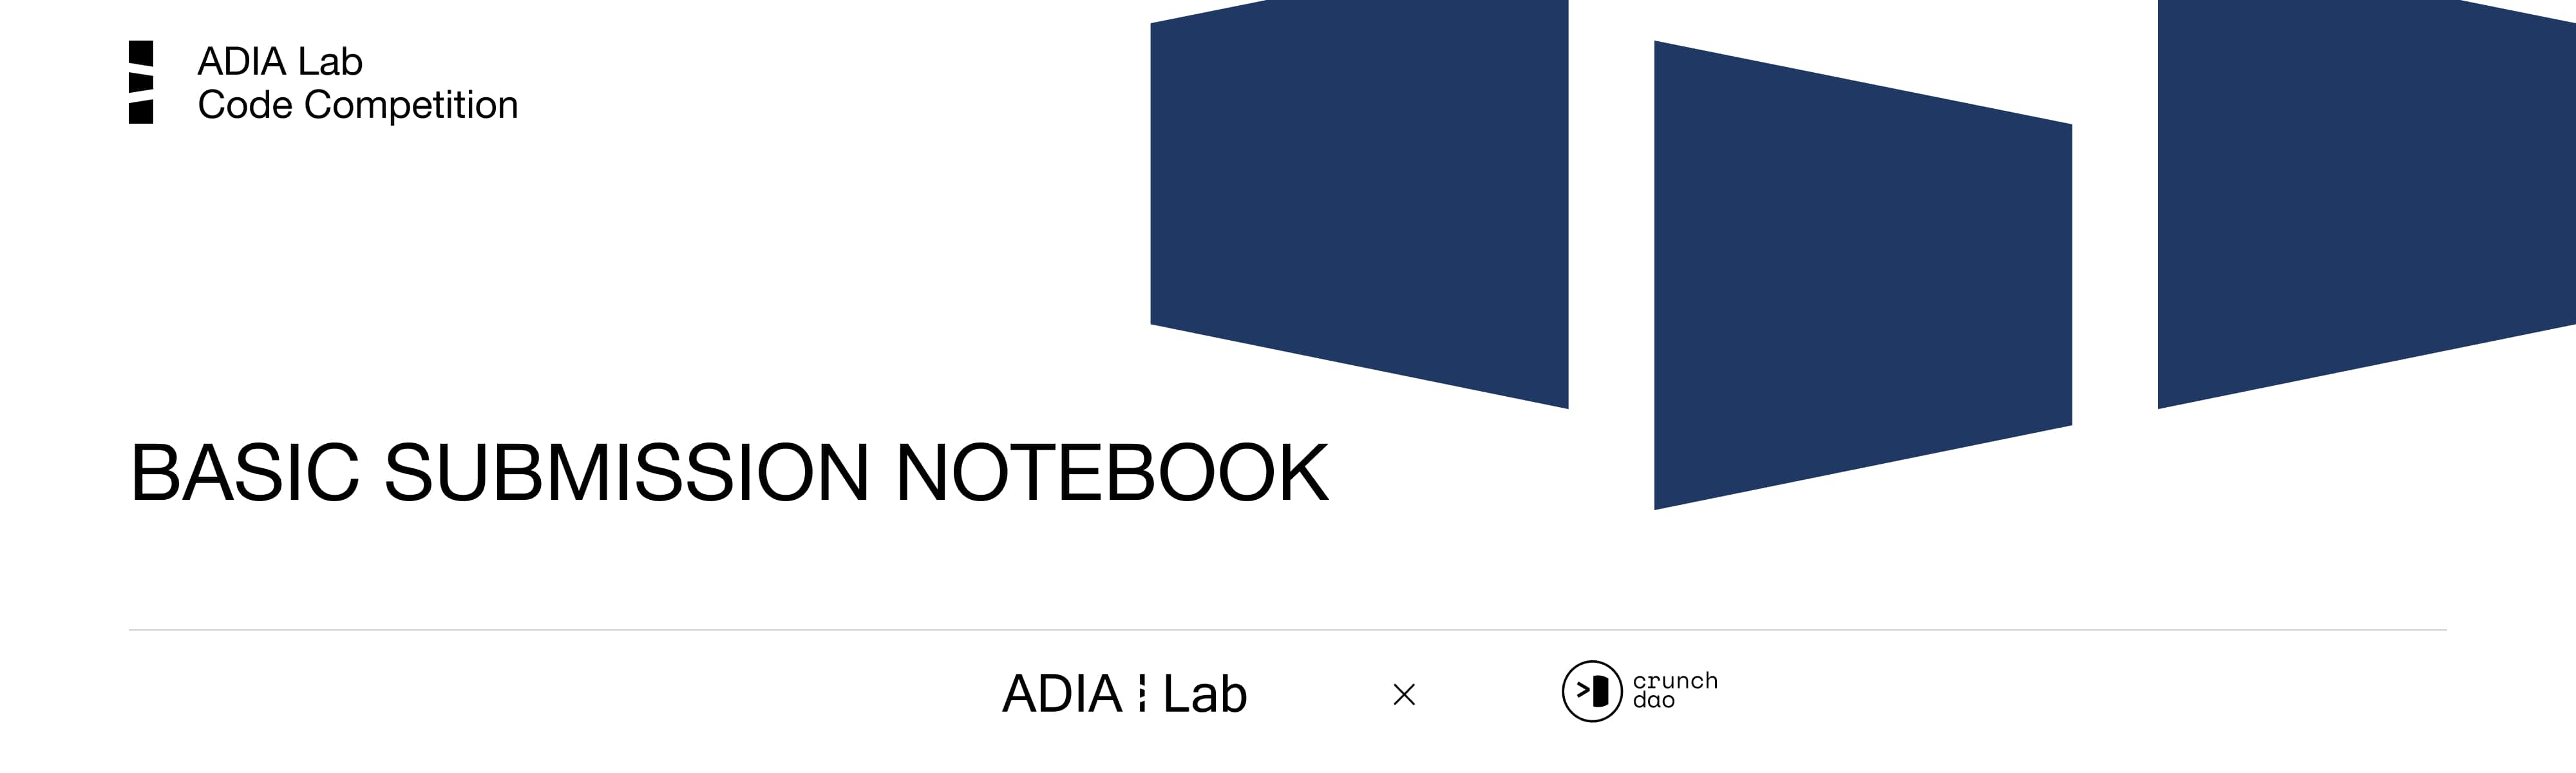

# Set up your crunch workspace

#### STEP 1
Run this cell to install the crunch library in your workspace.

In [ ]:
!pip3 install crunch-cli --upgrade

#### STEP 2
Import the crunch package and instantiate it to be able to access its functionality.

In [ ]:
import crunch
crunch = crunch.load_notebook(__name__)

#### STEP 3

In [ ]:
# go to your submit page and copy paste your setup command to access the data
# https://adialab.crunchdao.com/submit
%pip install crunch-cli --upgrade
!crunch --notebook setup uranium --token YcKYukVIurftjT5APG5fLZdvmiJTSDOb7Z1NfSAVlVU097d5r5viObtVluo09ERh
%cd uranium

# ADIA Lab Market Prediction

## A code competition

This competition is divided in two phases.

Submission phase - 12 weeks

Out-of-Sample phase - 12 weeks

During the first phase, participants will submit Python notebooks or Python scripts which build their best possible model on the data proposed by the organizers. In the second phase, also called [Out-of-Sample](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) (OOS) phase, the participant's code will be automatically executed by the platform on unseen data. During this phase, the participants won't be able to modify their code.

There are two main reasons for this:

- Participants won't be able to game or cheat their scores.

- [Overfitting](https://deliverypdf.ssrn.com/delivery.php?ID=634087103098022017102089127026118070055022030067038035066070070118003108076075122073107013020035005031116084117030102014013119017036066065011126115081078006004108029033051020066006092025091103065117104075029100098011096065096065079019015002101078070&EXT=pdf&INDEX=TRUE) of the training data will lead to very bad performance OOS.

To ensure reproducibility of your work, you will need to follow certain coding guidelines to participate in the competition. These guidelines will also allow our scoring system to run your code in the cloud during the OOS period without any issues.

In this competition, CrunchDAO acts as a third party intermediary and will never communicate this code to the organizers.

## The Coding Guideline

Your submission needs at least to provide three components: imports, `train()`, and `infer()`.

1. **imports**: As with any script, if your solution contains dependencies on external packages make sure to import them. The system will automatically install your dependancies. Make sure that you are using only packages that are whitelisted [here](https://adialab.crunchdao.io/submit?tab=libraries).

2. **`train()`**: In the training phase the users will build the model and train it such that it can perform inferences on the testing data. The model must be saved in the `resources` directory.

4. **`infer()`**: In the inference function the model trained in the previous step will be loaded and used to perform inferences on a data sample matching the characteristic of the training test.

## Scoring on the public leaderboard

To ensure the reliability of the public leaderboard, you don't have access to all of the testing data on which you will be scored.
The `X_test` data downloaded in your workspace is composed of **only** 5 dates to test locally that your code actually runs when submitted. Notice that `y_test` is not available for those 5 dates.
Once you have uploaded your solution the system will run your code on a larger test set of approximately 30 dates, and compute the score.

When submitting, you are left to decide how frequently to retrain your model, considering the limit of 5 hours of resources / week / user allowed to predict the 30 dates of the private test set.


## Scoring on the out-of-sample phase

During the out-of-sample phase, after the submission period ends, the system will call your code 3 times every week on live datapoint.

The mean spearman score after 12 weeks of OOS will determine the winners of the tournament.


# Construction of a basic submission

### Submission process

1- Make sure to put all your code in the code interface inside your Notebook. The system will parse these functions to execute it in the cloud. You can work outside of the code interface but to be able to submit you will need to fill in the submission function with the code you want to submit

2- Once satisfied with your work. Download this notebook ( file -> Download -> Download.ipynb )

3- Then upload this Notebook on https://adialab.crunchdao.com/submit



In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import typing
import joblib
from pathlib import Path
from scipy.stats import pearsonr
from sklearn.datasets import make_regression

def train(X_train: pd.DataFrame, y_train: pd.DataFrame,
          model_directory_path: str = "resources") -> None:
    # Calculate correlation matrix
    correlation_matrix = X_train.iloc[:, 2:].corr()

    # Finding least correlated features
    least_correlated_features = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            column_i = X_train.iloc[:, i]
            column_j = X_train.iloc[:, j]

            # Check if both columns are numeric before calculating correlation
            if column_i.dtype == 'float64' and column_j.dtype == 'float64':
                correlation = correlation_matrix.iloc[i, j]
                p_value = pearsonr(column_i, column_j)[1]

                if abs(correlation) <= 0.44 and p_value < 0.05: # Correlation less than 44% and significance less than 0.05
                    least_correlated_features.add(correlation_matrix.columns[i])
                    least_correlated_features.add(correlation_matrix.columns[j])

    # Selecting Unique Features
    unique_least_correlated_features = list(set(least_correlated_features))

    # Use only unique highly correlated features
    X_train_filtered = X_train[unique_least_correlated_features]  # Use only least correlated features

    # Define the parameters for the Gradient Boosting Regressor
    params = {
        "n_estimators": 500,
        "max_depth": 4,
        "min_samples_split": 5,
        "learning_rate": 0.01,
        "loss": "squared_error",
        "subsample": 0.8,
        "max_features": 0.8,
        "min_samples_leaf": 2,
        "max_leaf_nodes": 10,
        "alpha": 0.1,
        "random_state": 42,
        "init": None,
        "warm_start": False,
        "validation_fraction": 0.1,
        "n_iter_no_change": 10,
        "criterion": "friedman_mse",
        "min_weight_fraction_leaf": 0.0,
        "min_impurity_decrease": 0.0,
        "verbose": 0,
        "ccp_alpha": 0.0,        
        "tol": 1e-4,

    }
       

    # Create and fit the Gradient Boosting Regressor model
    model = GradientBoostingRegressor(**params)

    model.fit(X_train, y_train)

    # Training the model
    print("Training...")
    model.fit(X_train_filtered, y_train.iloc[:,2:])

    # Make sure that the train function correctly saves the trained model
    model_pathname = Path(model_directory_path) / "model.joblib"
    print(f"Saving model in {model_pathname}")
    joblib.dump(model, model_pathname)


def infer(X_test: pd.DataFrame,
          model_directory_path: str = "resources") -> pd.DataFrame:
    """
    Do your inference here.
    This function will load the model saved at the previous iteration and use
    it to produce your inference on the current date.
    It is mandatory to send your inferences with the ids so the system
    can match it correctly.

    Args:
        model_directory_path: the path to the directory to the directory in which we will be saving your updated model.
        X_test: the independent variables of the current date passed to your model.

    Returns:
        A dataframe (date, id, value) with the inferences of your model for the current date.
    """

    # Loading the model saved by the train function at previous iteration
    model = joblib.load(Path(model_directory_path) / "model.joblib")

    # Creating the predicted label dataframe with correct dates and ids
    y_test_predicted = X_test[["date", "id"]].copy()
    y_test_predicted["value"] = model.predict(X_test.iloc[:, 2:])

    return y_test_predicted




---


# Testing your model locally

This last part of the notebook is not necessary for the submission but only for you, to analyze your model.

In [ ]:
from scipy.stats import spearmanr

In [ ]:
# Getting the data
X_train, y_train, X_test = crunch.load_data()

To have a preliminary assessment of our solution above we need to create train and test data:

In [ ]:
def temporal_train_test_split(X_train_loc, y_train_loc, test_size=0.2):
    unique_dates = X_train_loc.date.unique()
    split_date = unique_dates[int(len(unique_dates)*(1-test_size))]
    X_train_local = X_train_loc[X_train_loc['date'] <= split_date]
    X_test_local = X_train_loc[X_train_loc['date'] > split_date]
    
    y_train_local = y_train_loc[y_train_loc['date'] <= split_date]
    y_test_local = y_train_loc[y_train_loc['date'] > split_date]
    
    return X_train_local, X_test_local, y_train_local, y_test_local

In [ ]:
print("Splitting (X_train, y_train) in X_train_local, X_test_local, y_train_local, y_test_local")
X_train_local, X_test_local, y_train_local, y_test_local = temporal_train_test_split(
    X_train,
    y_train,
    test_size=0.2
)

In [ ]:
# Training. It may require a few minutes.
train(X_train_local, y_train_local)

In [ ]:
print("Inference")
y_test_local_pred = infer(X_test_local, model_directory_path="resources")
score = spearmanr(y_test_local["y"], y_test_local_pred["value"])[0] * 100
print(f"Spearman's correlation {score}")

# Testing your submission **locally**

This function of the crunch package will run your code locally, in the same way in which the function is called in the cloud (ie: one date at a time). If it runs without problem, it is highly likely that there won't be problems when executing it on the CrunchDAO's system, on the cloud.

You can setup the a retraining frequency as you which. A train frequency of 2 means that the system will retrain your model every two dates.

`force_first_train=True` means that your model will be trained on the first date of the test set.

In [ ]:
print("Remove unused data to release memory")
del X_train, y_train, X_test, X_train_local, X_test_local, y_train_local, y_test_local

In [ ]:
crunch.test(force_first_train=True, train_frequency=2)

# Now remember to download and then submit this notebook to https://adialab.crunchdao.com/submit